This is an example of how to run RADEX from a Jupyter notebook in order to constrain excitation temperature. The parameters I'm using are for ortho-$\text{NH}_2\text{D}$ in prestellar core L43E.

This code is modified from the radex_column.py code in the Radex installation package by Floris van der Tak in 2006.

In [19]:
import numpy as np
import pandas as pd
import itertools
import math
import os
import sys
import astropy.units as u
import astropy.table as tbl
from matplotlib import pyplot as plt
import matplotlib as mpl

new_rcParams = {
    'figure.dpi': 150
}
mpl.rcParams.update(new_rcParams)

In [20]:
infile = 'testfile.inp'
outfile = 'testfile.out'
radexpath = '/path/to/radex'

In [21]:
def get_params(params):

    permutations = list(itertools.product(params['tkin'], params['cdmol']))
    param_list = []

    for permutation in permutations:
        option = dict.copy(params)
        option['tkin'] = permutation[0]
        option['cdmol'] = permutation[1]
        param_list.append(option)

    return param_list

In [58]:
params = {'molfile': 'onh2d.dat',
        'tkin': np.linspace(11, 12, 5),
        'tbg':2.73,
        'cdmol': np.linspace(5e10, 1.45e14, 15),
        'h2': 3.2e4,
        'dv': 0.325,
        'fmin': 85,
        'fmax': 86, 
        'I_obs': 0.005868,
        }

param_list = get_params(params)

In [59]:
def write_input(params, infile, outfile):
    '''This function writes the .inp file for Radex from the parameter dictionary.
    
    Inputs:
    -------
            params (dict): the input dictionary formatted as specified above

    '''
    partner_types = ['h2', 'h', 'e-', 'p-h2', 'o-h2', 'h+']
    partners = []
    for partner in partner_types:
        if partner in params.keys():
            partners.append(partner)
    file = open(infile, 'w')
    file.write(params['molfile']+'\n')
    file.write(outfile+'\n')
    file.write(str(params['fmin'])+' '+str(params['fmax'])+'\n')
    file.write(str(params['tkin'])+'\n')
    file.write(str(len(partners))+'\n')
    for partner in partners:
        file.write(partner+'\n')
        file.write(str(params[partner])+'\n')
    file.write(str(params['tbg'])+'\n')
    file.write(str(params['cdmol'])+'\n')
    file.write(str(params['dv'])+'\n')
    if 'geometry' in params.keys():
        file.write(str(params['geometry']))
    else:
        file.write('0\n')
    file.close()

In [60]:
def read_radex(cdmol, tkin, outfile, table):
    '''This file reads the Radex .out file to report the results.
    
    Inputs:
    -------
            cdmol (float) : the input column density in cm^-2
            tkin (float)  : the input kinetic gas temperature in K
            outfile (str) : the name of the output file, ending in .out
            table (QTable): the pre-existing table to be added to
    Outputs:
    --------
            table (QTable): the relevant output information from Radex
    '''
    file  = open(outfile, 'r')
    lines = file.readlines()
    file.close()
    if (lines[-2].split()[-1] != '(erg/cm2/s)'):
        print("Error: Ambiguous line selection. Reduce bandwidth?")
        sys.exit()
    freq = float(lines[-1].split()[-9])*u.GHz
    Tex = float(lines[-1].split()[-7])*u.Kelvin
    tau = u.Quantity(float(lines[-1].split()[-6]))
    flux_SI = float(lines[-1].split()[-2])*u.Kelvin*u.km/u.s
    flux_cgs = float(lines[-1].split()[-1])*u.erg*(u.cm**(-2))/u.s
    table.add_row((cdmol*(u.cm**(-2)), tkin*u.Kelvin, freq, Tex, tau, flux_SI, flux_cgs))
    return table

In [61]:
table = tbl.QTable(names = ('Input Column Density', 'Input T_kin', 'Frequency', 'T_ex', 'Tau', 
                            'Flux (SI)', 'Flux (CGS)'))
for params in param_list:
    write_input(params, infile, outfile)
    os.system(radexpath+' < '+infile+' > /dev/null')
    read_radex(params['cdmol'], params['tkin'], outfile, table)

In [62]:
#create a dictionary to store the different dependencies on kinetic gas temperature
tkin_dict = {}
for key in np.unique(np.array(table['Input T_kin'].tolist())):
    tkin_dict[str(key)] = [[], []]

for line in table:
    tkin_dict[str(line[1])][0].append(line[0])
    tkin_dict[str(line[1])][1].append(line[3])

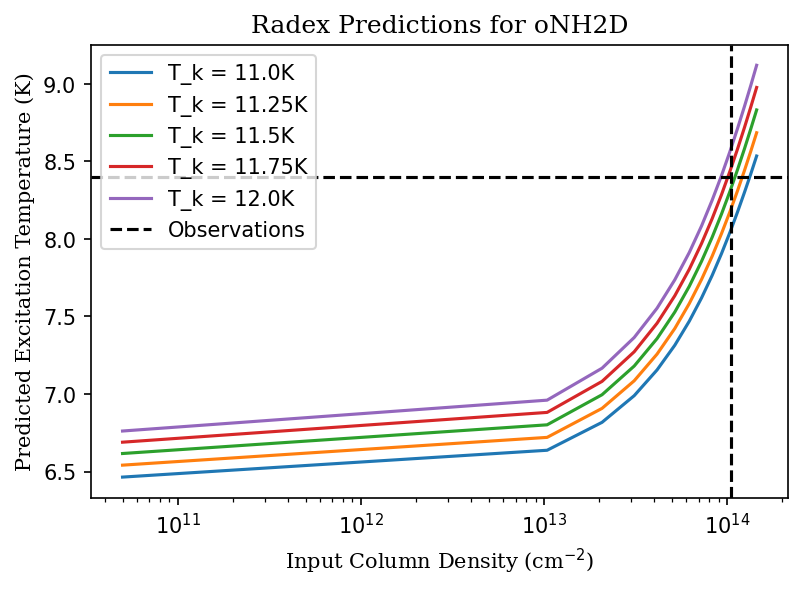

In [63]:
for tkin in tkin_dict:
    plt.plot(tkin_dict[tkin][0], tkin_dict[tkin][1], label = 'T_k = '+tkin+'K')


plt.axhline(8.4, color = 'k', linestyle = '--', label = 'Observations')
plt.axvline(1.05e14, color = 'k', linestyle = '--')
plt.legend()
plt.ylabel('Predicted Excitation Temperature (K)', family = 'serif')
plt.xlabel(r'Input Column Density (cm$^{-2}$)', family = 'serif')
plt.title('Radex Predictions for oNH2D', family = 'serif')
plt.semilogx()
plt.savefig('radexL43E.png')
plt.show()